In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# %matplotlib qt 
from scipy import ndimage as ndi
from skimage.filters import threshold_li
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage.morphology import disk, opening, remove_small_objects
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage import color, feature


img = plt.imread('4.tif')  #clear: Boyden Chamber/CD345_LN229_Ctrl/8.tif
r = img[:,:,0].astype(np.int32)
g = img[:,:,1].astype(np.int32)
b = img[:,:,2].astype(np.int32)
print(b.shape)

(1550, 2088)


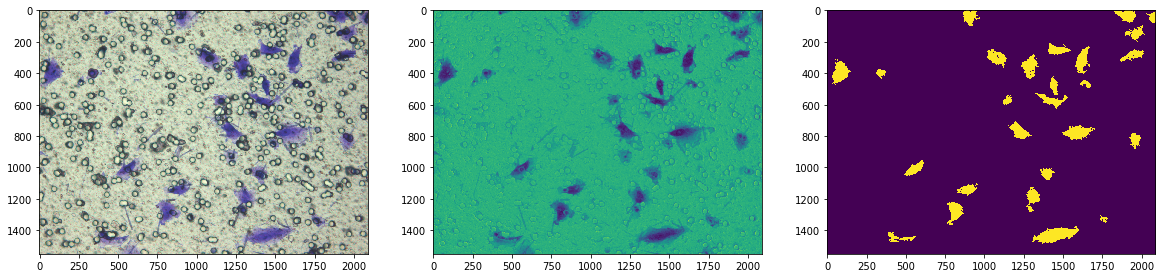

In [10]:
sub_rgb = (g-b)/(r+g+b)
# sub_rgb = (sub_rgb-np.min(sub_rgb))/(np.max(sub_rgb)-np.min(sub_rgb))
thresh = threshold_li(sub_rgb)
# print(thresh)
binary_rgb = sub_rgb < thresh
binary_rgb = remove_small_objects(binary_rgb, 1000).astype(np.int64)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(img)
plt.subplot(1,3,2)
plt.imshow(sub_rgb)
# plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(binary_rgb)
# plt.axis('off')
# plt.savefig('test.png',bbox_inches='tight')

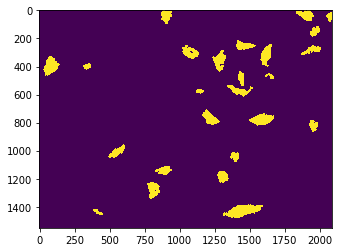

In [11]:
# opening
selem = disk(7)
eroded = opening(binary_rgb,selem)
eroded = remove_small_objects(eroded.astype(bool), 1000).astype(np.int64)
plt.imshow(eroded)

In [4]:
# record all cell sizes in this image
area = []
labels = label(eroded)
for region in regionprops(labels):
    area.append(region.area)

#watershed
distance = ndi.distance_transform_edt(eroded)
local_max_coords = feature.peak_local_max(distance, min_distance=40,exclude_border=0)
local_max_mask = np.zeros(distance.shape, dtype=bool)
local_max_mask[tuple(local_max_coords.T)] = True
markers = label(local_max_mask)
labels = watershed(-distance, markers, mask=eroded,watershed_line=True)

#only do watershed on large size cells
large = remove_small_objects(eroded.astype(bool), 2*np.median(np.array(area))).astype(np.int64)
final = label(eroded)
final[large>0] = labels[large>0]
final = label(final)
final = remove_small_objects(final, 1000).astype(np.int64)

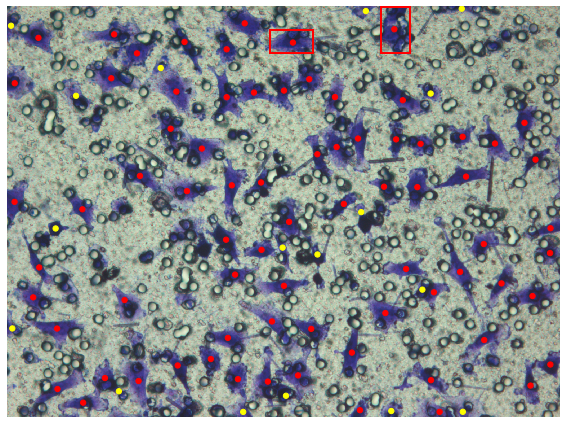

In [5]:
#plot
labels = label(eroded)
for region in regionprops(labels):
    area.append(region.area)
mid = np.median(np.array(area))
    
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(img)

for region in regionprops(labels):
    if region.area >= 2*mid:       
        y,x = region.centroid
        ax.add_patch(plt.Circle((x, y), 10, color='red'))
        #bound
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
    elif region.area < mid/2:
        y,x = region.centroid
        ax.add_patch(plt.Circle((x, y), 10, color='yellow'))
    else:
        y,x = region.centroid
        ax.add_patch(plt.Circle((x, y), 10, color='r'))
        
ax.set_axis_off()
plt.tight_layout()
plt.show()